In [22]:
# import libraries
import numpy as np
import pandas as pd
import torch
from pathlib import Path
import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
import sys
import importlib

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache
from cnn_functions import *
from prepare_data import *

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# import unit cluster IDs
df      = pd.read_csv(r'C:\Users\nnitzan\vis_clusters\cluster_ids.csv')
# df.set_index('unit_id', inplace=True)
print(df.head())

cuda:0
      unit_id  cluster_id
0  1179685455           4
1  1179685422           2
2  1179685420           1
3  1179685635           1
4  1179685392           1


In [3]:
warnings.filterwarnings("ignore", message="Ignoring cached namespace")

output_dir = r"C:\Users\nnitzan\Allen_Institute_Data"
output_dir = Path(output_dir)
cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=output_dir)
session_id = 1044385384 # Arbitrary pick
session = cache.get_ecephys_session(ecephys_session_id=session_id)
behavior_id = session.behavior_session_id
behavior = cache.get_behavior_session(behavior_id)

In [12]:
units = session.get_units()
spike_times = session.spike_times
start = behavior.stimulus_presentations.start_time[behavior.stimulus_presentations.active].iloc[0]- 1
stop  = behavior.stimulus_presentations.end_time[behavior.stimulus_presentations.active].iloc[-1] + 1
stimSt = behavior.stimulus_presentations.start_time[behavior.stimulus_presentations.active]

# keep only units that are in the dataframe
units  = units[units.index.isin(df.unit_id)]
df_ses = df[df.unit_id.isin(units.index)].copy()

In [13]:
# balance the number of clusters by keeping only the minimum number of clusters
# get total numbers of clusters for each cluster
n_clusters = df_ses.groupby('cluster_id').size()
keep = []
for cluster in n_clusters.index:
    keep.append(df_ses.unit_id[df_ses.cluster_id == cluster].sample(n_clusters.min()).values)

df_ses = df_ses[df_ses.unit_id.isin(np.concatenate(keep))]
labels = df_ses.cluster_id.values - 1

In [14]:
bin_size = 0.01
sigma=3
win = [-.25, .5]

spkMat, timestamps = getSpkMat(spike_times, df_ses.unit_id, start, stop,bin_size, sigma)
Data, t = getSnippets(win, spkMat, timestamps, stimSt)

100%|██████████| 4800/4800 [00:12<00:00, 370.96it/s]


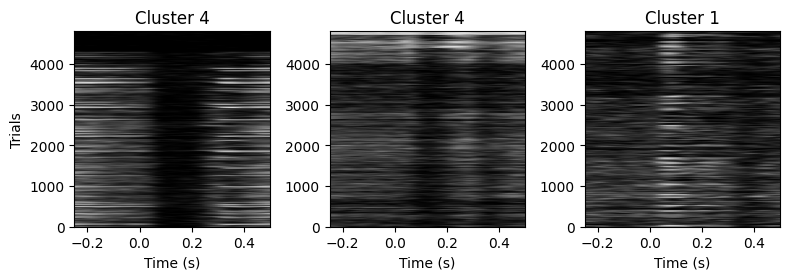

In [15]:
# plot 3 random rasters
fig, axs = plt.subplots(1, 3, figsize=(8, 8))

axs[0].imshow(Data[38,0,:,:].T, aspect='auto', cmap='gray', extent=[win[0], win[1], 0, Data[0].shape[2]], vmin=0, vmax=2)
axs[0].set_aspect(1.0/axs[0].get_data_ratio(), adjustable='box')
axs[0].set_title('Cluster ' + str(labels[38] + 1))
axs[0].set_ylabel('Trials')
axs[0].set_xlabel('Time (s)')

axs[1].imshow(Data[6,0,:,:].T, aspect='auto', cmap='gray', extent=[win[0], win[1], 0, Data[0].shape[2]], vmin=0, vmax=2)
axs[1].set_aspect(1.0/axs[0].get_data_ratio(), adjustable='box')
axs[1].set_title('Cluster ' + str(labels[6] + 1))
axs[1].set_xlabel('Time (s)')

axs[2].imshow(Data[17,0,:,:].T, aspect='auto', cmap='gray', extent=[win[0], win[1], 0, Data[0].shape[2]], vmin=0, vmax=2)
axs[2].set_aspect(1.0/axs[0].get_data_ratio(), adjustable='box')
axs[2].set_title('Cluster ' + str(labels[17] + 1))
axs[2].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

In [16]:
# split data into training and testing sets and create data loaders
train_loader,test_loader = getDataLoaders(Data,labels)
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )
print( test_loader.dataset.tensors[0].shape )
print( test_loader.dataset.tensors[1].shape )

torch.Size([120, 1, 75, 4500])
torch.Size([120])
torch.Size([30, 1, 75, 4500])
torch.Size([30])


In [35]:
importlib.reload(cnn_functions)
from cnn_functions import *
# create the model
# test the model with one batch
net,lossfun,optimizer = createNet(printtoggle=True)

X,y = next(iter(train_loader))
yHat = net(X)[0]
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

Input: torch.Size([32, 1, 75, 4500])
Layer conv1/pool1: torch.Size([32, 10, 36, 2249])
Layer conv2/pool2: torch.Size([32, 20, 17, 1123])
Layer conv3/pool3: torch.Size([32, 30, 7, 560])
Vectorize: torch.Size([32, 117600])
Layer fc1: torch.Size([32, 50])
Layer out: torch.Size([32, 5])
 
Loss:
tensor(1.6468, grad_fn=<NllLossBackward0>)


100%|██████████| 15/15 [00:22<00:00,  1.51s/it]


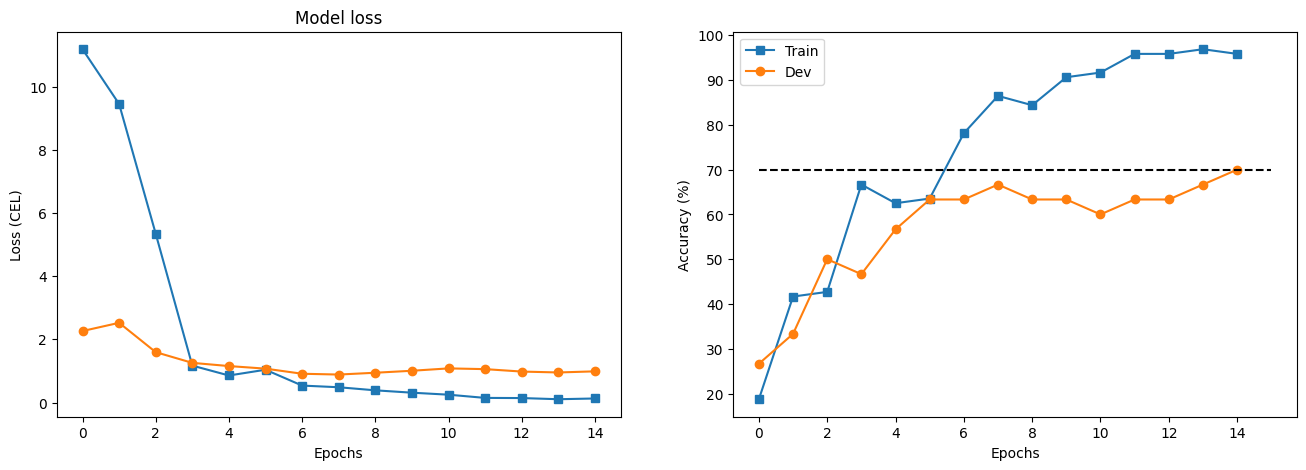

In [53]:
# train the model
net,lossfun,optimizer = createNet(weight_decay=0.001)
trainLoss,devLoss,trainAcc,devAcc,net = funtion2trainTheModel(net, 
                                                              lossfun, optimizer,
                                                              train_loader, test_loader, 
                                                              numepochs=15, 
                                                              device = device)

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
ax[1].plot([0,15],[70, 70],'k--')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend()

plt.show()

In [ ]:
filename = Path(f'C:\\Users\SB13FLPC018\\vis_clusters\\cnn_model_state_{session_id}.pth')
torch.save(net.state_dict(), filename)

In [ ]:
# load session IDs
sessions  = np.load(r'Y:\buzsakilab\Buzsakilabspace\LabShare\NoamNitzan\Open_Access\Allen_2022\ses2analyze.npy')
testAcc = pd.DataFrame.from_dict({'session': sessions[0].astype(int), 'accuracy': [None] * len(sessions[0]), 'confMat': [[]] * len(sessions[0])})

In [ ]:
# load the model we trained and set to evaluation mode
training_session = 1044385384
filename = Path(f'C:\\Users\SB13FLPC018\\vis_clusters\\cnn_model_state_{training_session}.pth') 
net,lossfun,optimizer = createNet() 
net.load_state_dict(torch.load(filename)) 
net.eval()

# run on all sessions 
for i, session_id in enumerate(sessions[0]):
    
    msg = f'Working on session {session_id}'
    sys.stdout.write('\r' + msg)
    
    session = cache.get_ecephys_session(ecephys_session_id=session)
    behavior_id = session.behavior_session_id
    behavior = cache.get_behavior_session(behavior_id)
    
    units = session.get_units()
    units  = units[units.index.isin(df.unit_id)]
    df_ses = df[df.unit_id.isin(units.index)].copy()
    
    # balance
    n_clusters = df_ses.groupby('cluster_id').size()
    keep = []
    for cluster in n_clusters.index:
        keep.append(df_ses.unit_id[df_ses.cluster_id == cluster].sample(n_clusters.min()).values)
    df_ses = df_ses[df_ses.unit_id.isin(np.concatenate(keep))]
    labels = df_ses.cluster_id.values - 1
    
    spike_times = session.spike_times
    start  = behavior.stimulus_presentations.start_time[behavior.stimulus_presentations.active].iloc[0]- 1
    stop   = behavior.stimulus_presentations.end_time[behavior.stimulus_presentations.active].iloc[-1] + 1
    stimSt = behavior.stimulus_presentations.start_time[behavior.stimulus_presentations.active]

    spkMat, timestamps = getSpkMat(spike_times, df_ses.unit_id, start, stop,bin_size, sigma)
    Data, t = getSnippets(win, spkMat, timestamps, stimSt)
    
    # restrict to first 4500 stimuli
    Data = Data[:,:,:,:4500]
    labels = np.squeeze(labels[:4500]) - 1

    net,lossfun,optimizer = createNet() 

    if Data.shape[3] < 4500:
        testAcc['accuracy'].iloc[i] = np.nan
    else:
        # convert to tensor
        dataT   = torch.tensor( Data ).float()
        labelsT = torch.tensor( labels ).long()
        yHat = net(dataT)
        
        pred = np.argmax(yHat[0].detach().numpy(), axis=1)
        predAcc = torch.mean((torch.argmax(yHat[0],axis=1) == labelsT).float()).item()
        cm = confusion_matrix(pred, labelsT.detach().numpy())

        print(f' session {session_id} accuracy: {predAcc}')
        testAcc['accuracy'].iloc[i] = predAcc
        testAcc['confMat'].iloc[i]  = cm

In [ ]:
x = testAcc.confMat.values
x = np.stack(x)
np.save('confMat.npy', x)
testAcc[['session','accuracy']].to_csv('visCNN_testAcc.csv', index=False)